In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [25]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [26]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32

In [27]:
ds = tf.keras.preprocessing.image_dataset_from_directory("data", batch_size=BATCH_SIZE, image_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 16011 files belonging to 10 classes.


In [28]:
class_names = ds.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

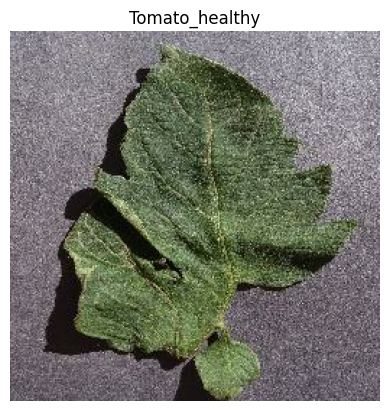

In [29]:
image = ds.as_numpy_iterator().next()
plt.imshow(image[0][0].astype(int))
plt.title(class_names[image[1][0]])
plt.axis("off")
plt.show()

In [30]:
len(ds)

501

In [31]:
train_size = int(len(ds) * 0.7)
val_size = int(len(ds) * 0.2) + 1
test_size = int(len(ds) * 0.1)

In [32]:
train_size + val_size + test_size

501

In [33]:
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

In [34]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
len(val_ds)

101

In [36]:
data_scaling = Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [37]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [45]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


model = Sequential()

model.add(data_scaling)
model.add(data_augmentation)

model.add(Conv2D(32, (3,3), activation="relu", input_shape=INPUT_SHAPE))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.build(input_shape=INPUT_SHAPE)
model.summary()

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [46]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=BATCH_SIZE)

Epoch 1/30
350/350 [==============================] - 49s 133ms/step - loss: 1.6676 - accuracy: 0.4153 - val_loss: 1.2250 - val_accuracy: 0.5777
Epoch 2/30
350/350 [==============================] - 46s 131ms/step - loss: 1.0308 - accuracy: 0.6474 - val_loss: 0.8330 - val_accuracy: 0.7172
Epoch 3/30
350/350 [==============================] - 46s 131ms/step - loss: 0.7130 - accuracy: 0.7531 - val_loss: 0.7087 - val_accuracy: 0.7466
Epoch 4/30
350/350 [==============================] - 46s 131ms/step - loss: 0.5618 - accuracy: 0.8009 - val_loss: 0.5461 - val_accuracy: 0.8001
Epoch 5/30
350/350 [==============================] - 46s 131ms/step - loss: 0.4492 - accuracy: 0.8420 - val_loss: 0.4341 - val_accuracy: 0.8506
Epoch 6/30
350/350 [==============================] - 46s 133ms/step - loss: 0.4020 - accuracy: 0.8637 - val_loss: 0.6834 - val_accuracy: 0.7562
Epoch 7/30
350/350 [==============================] - 46s 132ms/step - loss: 0.3400 - accuracy: 0.8838 - val_loss: 0.3231 - val_ac

In [48]:
model.evaluate(test_ds)

50/50 [==============================] - 1s 19ms/step - loss: 0.1516 - accuracy: 0.9493


[0.15161992609500885, 0.9493350386619568]

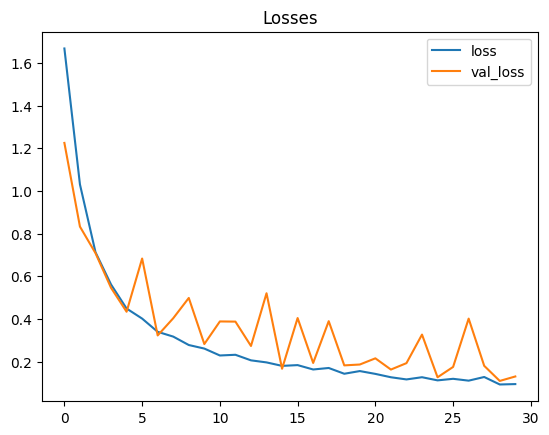

In [54]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Losses")
plt.legend()
plt.show()

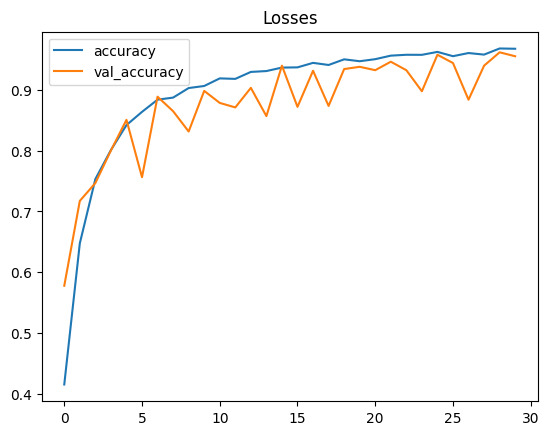

In [56]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Losses")
plt.legend()
plt.show()

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch(model expects a batch of images)
    
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred[0])]

    confidence = round(100 * (np.max(pred[0])), 2)

    return pred_class, confidence  

1/1 [==============================] - 0s 19ms/step


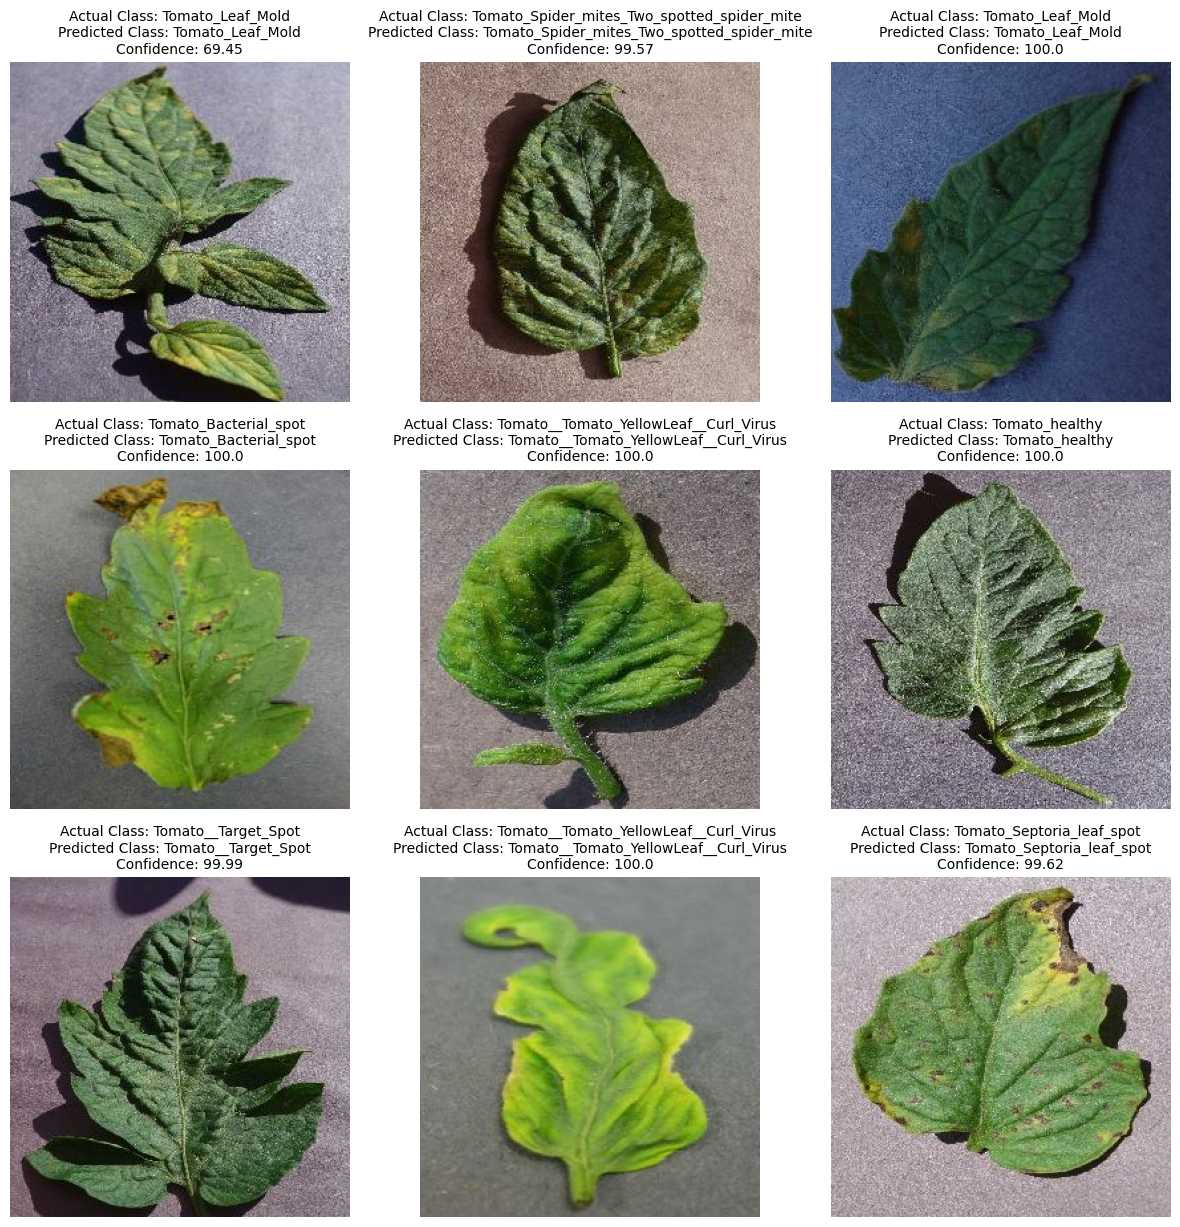

In [62]:
fig = plt.figure(figsize=(15,15))
for image, label in test_ds.take(1):
    for i in range(9):
        pred_class, confidence = predict(model, image[i].numpy())
        actual_class = class_names[label[i]]
        
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype(int))
        plt.axis("off")
        plt.title(f"Actual Class: {actual_class}\nPredicted Class: {pred_class}\nConfidence: {confidence}", fontsize=10)